In [3]:
import openturns as ot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from shapley import SobolIndices
from skgarden import RandomForestQuantileRegressor
from shapley.forest import compute_perm_indices, compute_shap_indices
from shapley.indices import SensitivityResults

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
from shapley.tests import Ishigami
ishigami = Ishigami()
dim = ishigami.dim
model = ishigami
model.copula = ot.NormalCopula(dim)

In [5]:
%%time 
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)

estimator = 'soboleff2'
n_boot = 200

n_tests = 10
min_n_sample = 100
max_n_sample = 2000
all_n_sample = np.linspace(min_n_sample, max_n_sample, n_tests, dtype=int)

sobol_results = {}
sobol = SobolIndices(model.input_distribution)

for n_sample in all_n_sample:
    print('n_sample: %d' % (n_sample))
    n_sample = int(n_sample)
    sobol_results[n_sample] = {}
    sobol.build_sample(model=model, n_sample=n_sample)
    sobol_results[n_sample]['monte-carlo'] = sobol.compute_indices(n_boot=n_boot, estimator=estimator)
    
    budget = n_sample*dim*4
    print('budget: %d' % (budget) )
    X = np.asarray(model.get_input_sample(budget, 'monte-carlo'))
    y = model(X)
    rfq = RandomForestQuantileRegressor(n_estimators=n_boot, n_jobs=7)
    rfq.fit(X, y)
    results_permutation = compute_perm_indices(rfq, X, y, model.input_distribution, indice_type='full')
    results_permutation.true_first_indices = model.first_sobol_indices
    results_permutation.true_total_indices = model.total_sobol_indices
    sobol_results[n_sample]['permutation'] = results_permutation

n_sample: 100
budget: 1200
n_sample: 311
budget: 3732
n_sample: 522
budget: 6264
n_sample: 733
budget: 8796
n_sample: 944
budget: 11328
n_sample: 1155
budget: 13860
n_sample: 1366
budget: 16392
n_sample: 1577
budget: 18924
n_sample: 1788
budget: 21456
n_sample: 2000
budget: 24000
Wall time: 27min


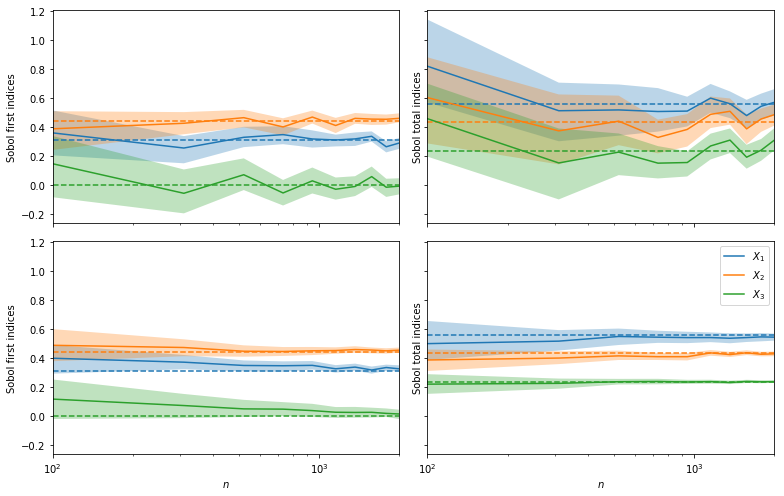

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(11, 7), sharex=True, sharey=True)
for k, method in enumerate((['monte-carlo', 'permutation'])):
    for l, indice in enumerate(['first', 'total']):
        ax = axes[k, l]
        true_indices = getattr(model, '%s_sobol_indices' % (indice))
        
        result = np.zeros((dim, n_tests, n_boot))
        for i, n_sample in enumerate(all_n_sample):
            result[:, i] = getattr(sobol_results[n_sample][method], 'full_%s_indices' % (indice))

        quantiles = np.percentile(result, [2.5, 97.5], axis=2)
        for i in range(dim):
            plot = ax.plot(all_n_sample, result[i].mean(axis=1), label='$X_%d$' % (i+1))
            ax.fill_between(all_n_sample, quantiles[0, i], quantiles[1, i], alpha=0.3)
            if model.first_sobol_indices is not None:
                ax.plot([min_n_sample, max_n_sample], [true_indices[i]]*2, '--', color=plot[0].get_color())

      
        ax.set_ylabel('Sobol %s indices' % (indice))
        if k == 1:
            ax.set_xlabel('$n$')
        ax.set_xscale('log')
    
ax.set_xlim(min_n_sample, max_n_sample)
ax.legend(loc=0)        

fig.tight_layout()
fig.savefig('output/montecarlo_vs_forest_convergence.pdf')
fig.savefig('output/montecarlo_vs_forest_convergence.png')